Generating Map chart...


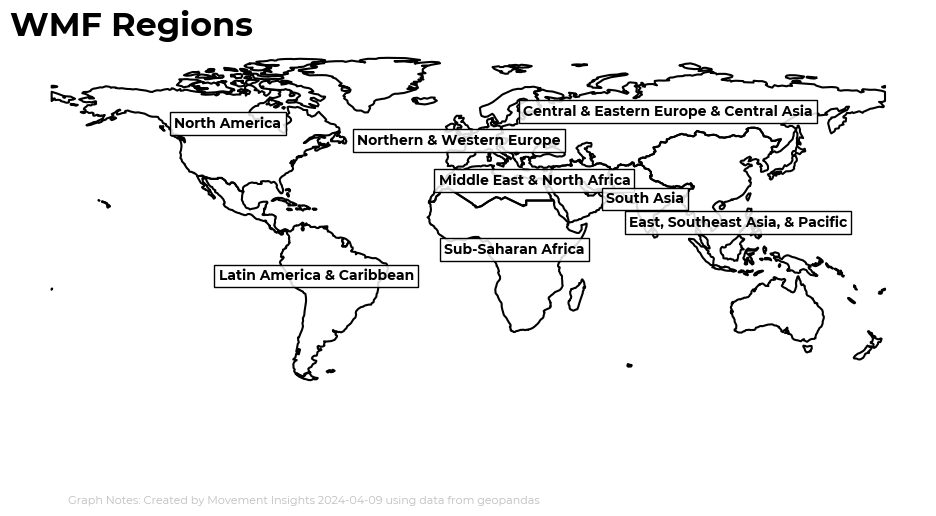

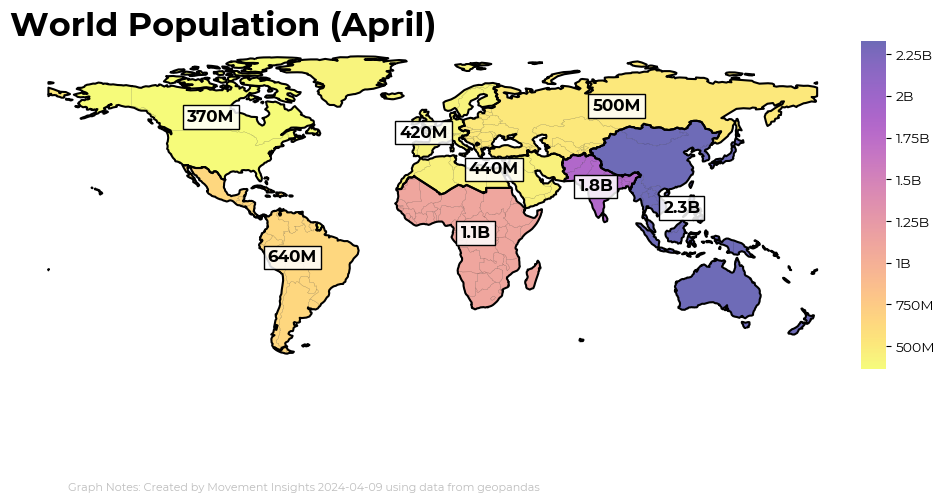

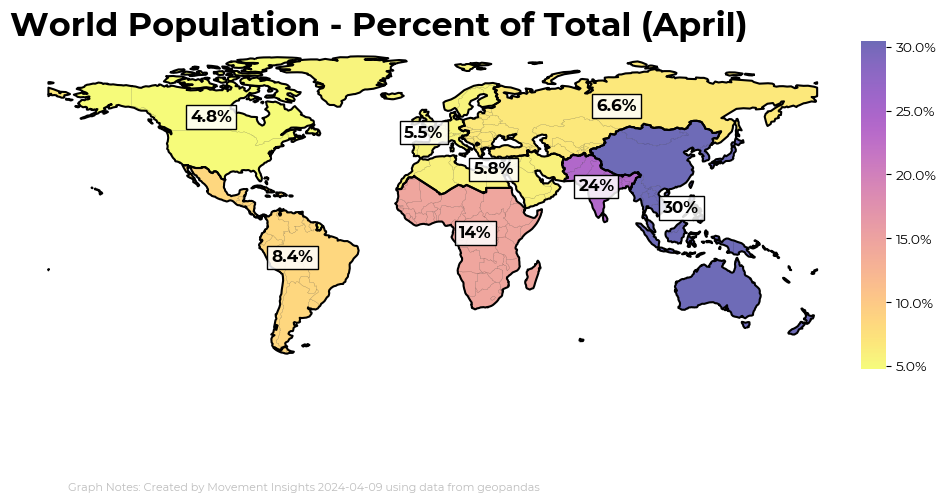

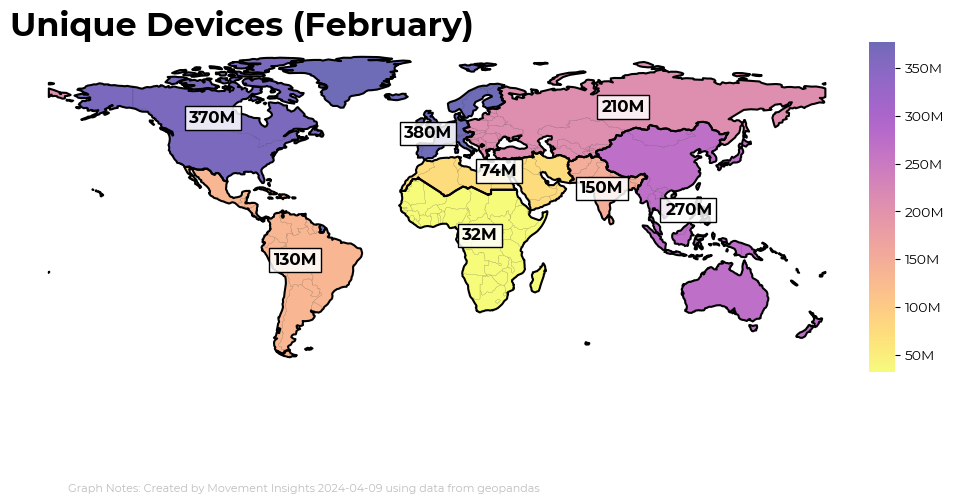

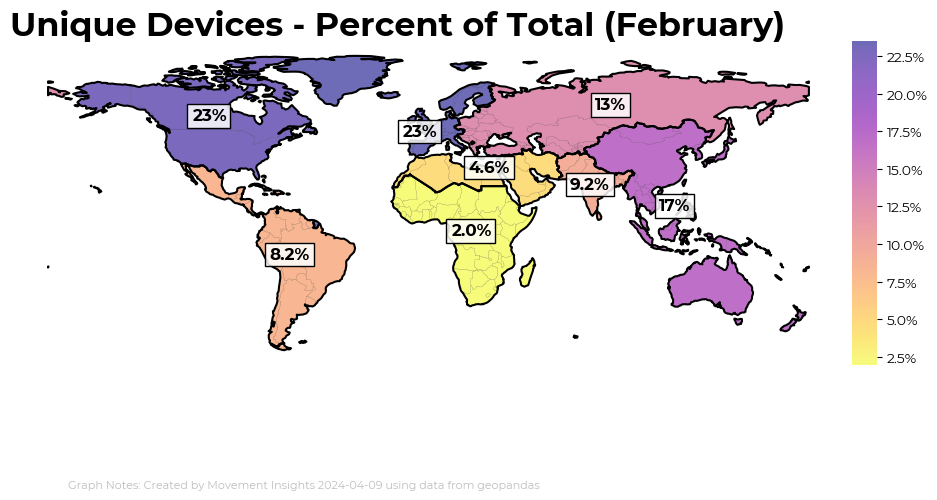

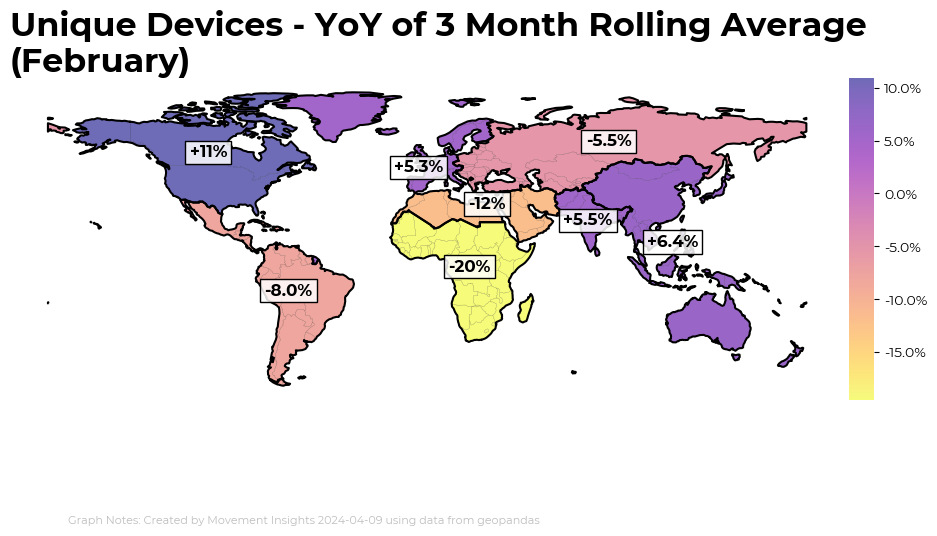

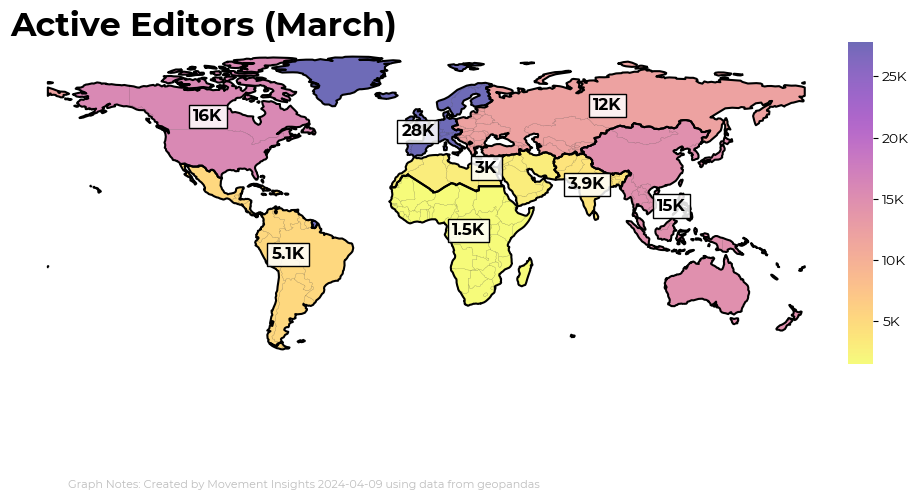

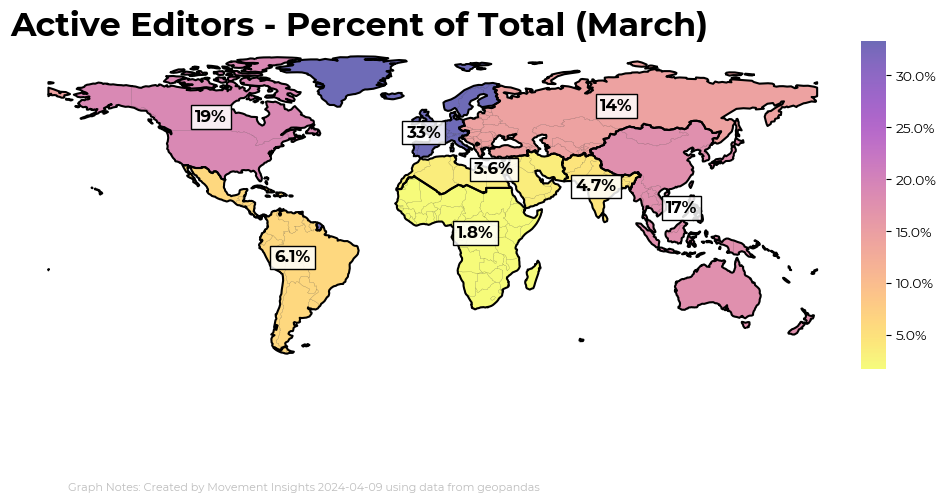

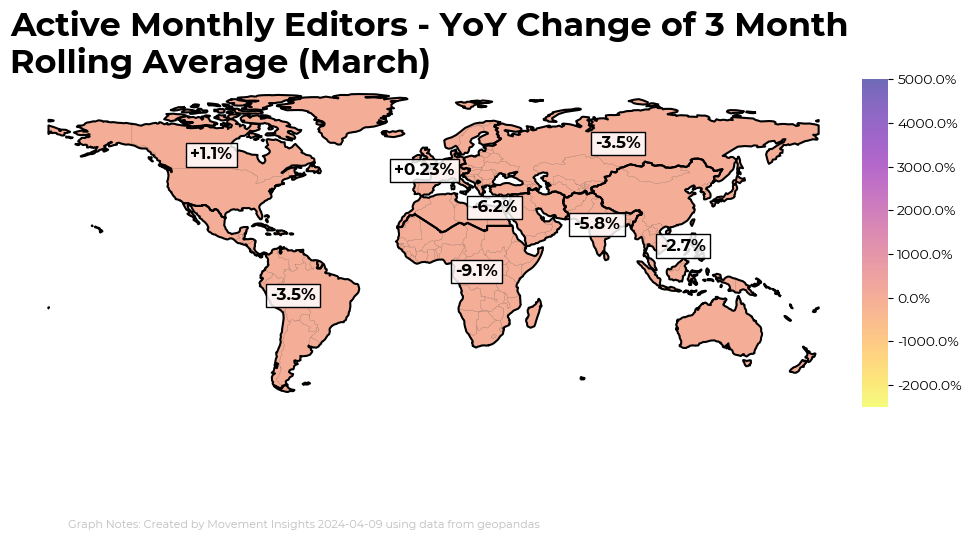

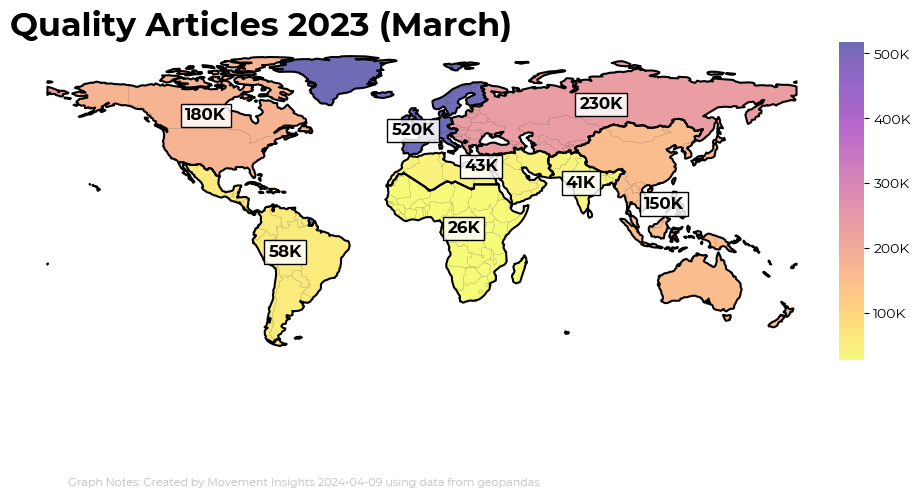

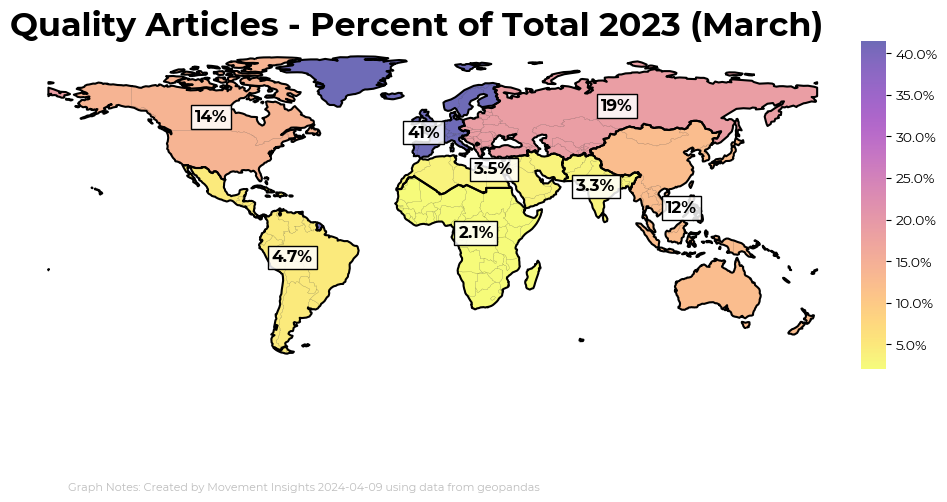

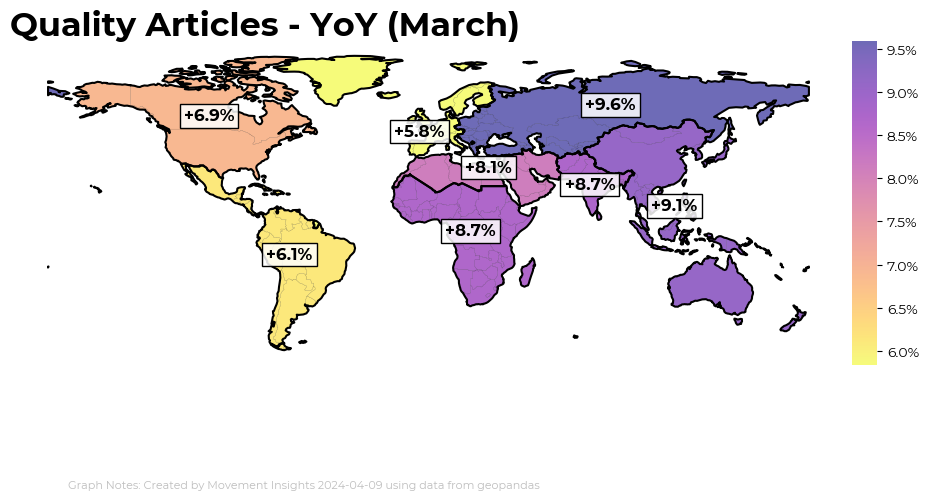

In [38]:
import datetime

from dateutil.relativedelta import relativedelta
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shapely
from shapely.ops import unary_union

import wmfdata as wmf
import parameters

# Wikicharts imports when running as a module
# from wikicharts import (
#     format_perc,
#     roll,
#     simple_num_format,
#     Wikimap,
#     wmf_colors,
#     wmf_regions
# )

# Wikicharts imports when running as a Jupyter notebook
%run wikicharts.ipynb

def main():
    print("Generating Map chart...")
    
    warnings.filterwarnings("ignore")

    #---PARAMETERS---
    #display or note
    display_flag = True
    #current month for population data
    current_month = datetime.today()

    #---WMF REGION DATA---
    #country code in iso-a3
    wmf_region_ref = wmf.presto.run("""
        SELECT
            name,
            iso_alpha3_code,
            wikimedia_region AS region
        FROM canonical_data.countries
    """)

    #---MAP (Borders) AND POPULATION DATA---
    raw_map_df = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres')) 
    map_df = raw_map_df[(raw_map_df.name != "Antarctica")]
    
    # match up wmf region data in wmf_region_ref with geographic data in map_df
    map_df = map_df.merge(wmf_region_ref, how='left', left_on="iso_a3", right_on="iso_alpha3_code")
    map_df = map_df[['name_x','iso_a3', 'pop_est', 'gdp_md_est', 'geometry', 'region']]
    map_df = map_df.rename(columns={"name_x": "name"})
    
    region_table = pd.pivot_table(
        map_df,
        values='pop_est',
        index=['region'],
        aggfunc=np.sum
    )
    
    region_table = region_table.rename(columns={'pop_est': 'sum_pop_est'})
    
    # Generate regional linestrings
    region_table['geometry'] = ''
    for region in wmf_regions:
        region_df = map_df.loc[map_df['region'] == region]
        region_polys = region_df['geometry'].values.tolist()
        region_boundary = gpd.GeoSeries(unary_union(region_polys))
        region_table.at[region,'geometry'] = region_boundary
    
    # Get representative centroid xys for each region
    region_table['centroid'] = region_table['geometry'].apply(lambda g: g.centroid)
    
    #---READER DATA---
    # Wrangle into expected format with columns "month", "region", and "unique_devices"
    reader_df = (
        pd
        .read_csv(unique_devices_data_path, sep="\t", parse_dates=["month"])
        .set_index("month")
        
        # Go from e.g. "northern_western_europe_unique_devices" to "Northern & Western Europe"
        .rename(lambda c: c.replace("_unique_devices", ""), axis=1)
        .rename({
            'subsaharan_africa': 'Sub-Saharan Africa',
             'latin_america_caribbean': 'Latin America & Caribbean',
             'middle_east_north_africa': 'Middle East & North Africa',
             'south_asia': 'South Asia',
             'north_america': 'North America',
             'east_southeast_asia_pacific': 'East, Southeast Asia, & Pacific',
             'northern_western_europe': 'Northern & Western Europe',
             'central_eastern_europe_central_asia': 'Central & Eastern Europe & Central Asia'
        }, axis=1)
        .rename_axis("region", axis=1)
        .stack(future_stack=True)
        .rename("unique_devices")
        .reset_index()
    )

    # Merge last month's values into regions table
    reader_last_month = reader_df.iloc[-1]['month']
    
    region_table = (
        region_table.merge(
            reader_df.query("month == @reader_last_month"),
            how='left',
            on="region"
        )
        .drop(columns=['month'])
    )

    #---EDITOR DATA---
    # Wrangle into expected format with columns "month", "region", and "active_editors"
    editor_df = (
        pd
        .read_csv(home_dir + '/resources/data/regional_editor_metrics.csv', parse_dates=["month"])
        .set_index("month")
        .rename_axis("region", axis=1)
        .stack(future_stack=True)
        .rename("active_editors")
        .reset_index()
    )

    # Merge last month's values into regions table
    editor_last_month = editor_df.iloc[-1]['month']
    
    region_table = (
        region_table.merge(
            editor_df.query("month == @editor_last_month"),
            how='left',
            on='region'
        )
        .drop(columns=['month'])
    )

    #---CONTENT DATA---
    # Wrangle into expected format with columns "region", "time_bucket", "standard_quality", and "standard_quality_count'
    content_df = (
        pd
        .read_csv(home_dir + '/resources/data/content_quality.csv', parse_dates=["time_bucket"])
        .rename(columns={"time_bucket": "month"})
        .drop(columns=['standard_quality'])
        .sort_values(by='month')
        .query("region != 'UNCLASSED' and ~region.isna()")
    )
    
    # Merge last month's values into regions table
    content_last_month = content_df.iloc[-1]['month']
    
    region_table = (
        region_table.merge(
            content_df.query("month == @content_last_month"),
            how='left',
            on='region'
        )
        .drop(columns=['month'])
    )
    
    #---VALUES---
    region_table['pop_label'] = region_table['sum_pop_est'].apply(simple_num_format, round_sigfigs=True)
    region_table['ud_label'] = region_table['unique_devices'].apply(simple_num_format, round_sigfigs=True)
    region_table['ed_label'] = region_table['active_editors'].apply(simple_num_format, round_sigfigs=True)
    region_table['sqc_label'] = region_table['standard_quality_count'].apply(simple_num_format, round_sigfigs=True)

    #---PERCENT OF TOTAL---
    region_table['pop_perc'] = region_table['sum_pop_est'] / region_table['sum_pop_est'].sum()
    region_table['pop_perc_label'] = (region_table["pop_perc"] * 100).apply(format_perc, sign=False)
    
    region_table['ud_perc'] = region_table['unique_devices'] / region_table['unique_devices'].sum()
    region_table['ud_perc_label'] = (region_table['ud_perc'] * 100).apply(format_perc, sign=False)
    
    region_table['ed_perc'] = region_table['active_editors'] / region_table['active_editors'].sum()
    region_table['ed_perc_label'] = (region_table['ed_perc'] * 100).apply(format_perc, sign=False)
    
    region_table['sqc_perc'] = region_table['standard_quality_count'] / region_table['standard_quality_count'].sum()
    region_table['sqc_perc_label'] = (region_table['sqc_perc'] * 100).apply(format_perc, sign=False)

    #---CHANGE OVER TIME---
    def change_over_time(var, change_var_name, data_df, region_table_local, days_delta = 0, months_delta=0, years_delta = 0):
        #get data for the most recent month
        current_df = data_df.loc[data_df['month'] == data_df.iloc[-1]['month']]
        #get data for time delta
        prev_time = data_df.iloc[-1]['month'].replace(day=1) - relativedelta(years=years_delta, months=months_delta, days=days_delta)
        prev_df = data_df.loc[data_df['month'] == prev_time]
        #names and labels
        var_x = var + "_x"
        var_y = var + "_y"
        growth_var_label = change_var_name + "_label"
        #comparison df
        growth_df = current_df.merge(prev_df, how='left',left_on="region", right_on="region")
        growth_df = growth_df.rename(columns={var_x:"current",var_y:"prev"})
        growth_df = growth_df.drop(columns=['month_x','month_y'])
        growth_df[change_var_name] = (growth_df["current"] - growth_df["prev"]) / growth_df["prev"]
        growth_df[growth_var_label] = (growth_df[change_var_name] * 100).map(format_perc)
        region_table_local = region_table_local.merge(growth_df.drop(columns=["current", "prev"]), how='left', on="region")
        return region_table_local
    
    #---YOY (Simple YOY for Content Only)---
    region_table = change_over_time("standard_quality_count", "sqc_yoy", content_df, region_table, years_delta=1)
    
    #---YOY of ROLLING AVERAGE---
    #get rolling average charts
    reader_pivot = pd.pivot_table(reader_df, values='unique_devices', index=['month'], columns=['region'], aggfunc=np.sum)
    reader_rolling3mo = reader_pivot.apply(lambda x: x.rolling(window=3).mean()).reset_index()
    reader_rolling3mo = pd.melt(reader_rolling3mo, id_vars="month", value_vars=wmf_regions)
    editor_pivot = pd.pivot_table(editor_df, values='active_editors', index=['month'], columns=['region'], aggfunc=np.sum)
    editor_rolling3mo = editor_pivot.apply(lambda x: x.rolling(window=3).mean()).reset_index()
    editor_rolling3mo = pd.melt(editor_rolling3mo, id_vars="month", value_vars=wmf_regions)
    
    #YOY of Rolling Average
    region_table = change_over_time("value", "ud_3morolling_yoy", reader_rolling3mo, region_table, years_delta=1)
    region_table = change_over_time("value", "ed_3morolling_yoy", editor_rolling3mo, region_table, years_delta=1)

    #---REMERGE W MAP_DF
    #merge pivot table with map data again — for generating colorbar
    #need to drop the geometry data from region_table or you will end up with a regular dataframe instead of a geoseries dataframe
    map_df = map_df.merge(region_table.drop(columns=['geometry','centroid']), how='left', on="region")

    #---ADDITIONAL LABELS---
    # at accessor and plot_regions require a region index, but plot_regions(region_table, 'region') also 
    # requires a region column
    region_table = region_table.set_index("region", drop=False)
    
    #manually adjust label positions (very complicated to do programmatically in matplotlib and not necessary)
    def adjust_label_position(region, x=0, y=0):
        current = region_table.at[region, 'centroid']
        region_table.at[region, 'centroid'] = shapely.Point(current.x + x, current.y + y)
        
    adjust_label_position('Middle East & North Africa', y=3)
    adjust_label_position('South Asia', y=-3)
    adjust_label_position('Northern & Western Europe', x=15, y=-18)
    adjust_label_position('Central & Eastern Europe & Central Asia', y=2)

    

    #---MAKE CHART---
    #---BLANK MAP WITH REGIONS LABELS---
    chart = Wikimap(
        map_df, fignum=0, title ='WMF Regions',
        data_source="geopandas", month=current_month,
        display_month=False
    )
    chart.plot_regions(region_table, 'region', fontsize=10)
    chart.format_map(format_colobar=False)
    save_file_name = "Map_RegionNames.png"
    chart.finalize_plot(save_file_name, display=True)

    #---WORLD POPULATION---
    chart = Wikimap(
        map_df, fignum=1, title='World Population',
        data_source="geopandas", month=current_month
    )
    chart.plot_wcolorbar(col = 'sum_pop_est')
    chart.plot_regions(region_table, 'pop_label')
    chart.format_map()
    save_file_name = "Map_WorldPop.png"
    chart.finalize_plot(save_file_name,display=True)

    #---WORLD POPULATION - PERCENT---
    chart = Wikimap(
        map_df, fignum=2, title = 'World Population - Percent of Total',
        data_source="geopandas", month=current_month
    )
    chart.plot_wcolorbar(col = 'pop_perc')
    chart.plot_regions(region_table, 'pop_perc_label')
    chart.format_map(cbar_perc=True)
    save_file_name = "Map_WorldPopPerc.png"
    chart.finalize_plot(save_file_name, display=True)

    #---READER METRICS - UNIQUE DEVICES---
    chart = Wikimap(
        map_df, fignum=3, title='Unique Devices',
        data_source="geopandas", month=reader_last_month
    )
    chart.plot_wcolorbar(col = 'unique_devices')
    chart.plot_regions(region_table, 'ud_label')
    chart.format_map()
    save_file_name = "Map_UniqueDevices.png"
    chart.finalize_plot(save_file_name, display=True)

    #---READER METRICS - UNIQUE DEVICES PERCENT---
    chart = Wikimap(
        map_df, fignum=4, title='Unique Devices - Percent of Total',
        data_source="geopandas", month=reader_last_month
    )
    chart.plot_wcolorbar(col='ud_perc')
    chart.plot_regions(region_table, 'ud_perc_label')
    chart.format_map(cbar_perc=True)
    save_file_name = "Map_UniqueDevicesPerc.png"
    chart.finalize_plot(save_file_name, display=True)
    
    #---READER METRICS - UNIQUE DEVICES YOY of 3MO ROLLING Average---
    chart = Wikimap(
        map_df, fignum=6, title='Unique Devices - YoY of 3 Month Rolling Average',
        data_source="geopandas", month=reader_last_month
    )
    chart.plot_wcolorbar(col='ud_3morolling_yoy')
    chart.plot_regions(region_table, 'ud_3morolling_yoy_label')
    chart.format_map(cbar_perc=True)
    save_file_name = "Map_UniqueDevicesYoy.png"
    chart.finalize_plot(save_file_name, display=True)

    #---EDITOR METRICS - ACTIVE MONTHLY EDITORS---
    chart = Wikimap(
        map_df, fignum=7, title='Active Editors',
        data_source="geopandas", month=editor_last_month
    )
    chart.plot_wcolorbar(col='active_editors')
    chart.plot_regions(region_table, 'ed_label')
    chart.format_map()
    save_file_name = "Map_Editors.png"
    chart.finalize_plot(save_file_name, display=True)

    #---EDITOR METRICS - ACTIVE MONTHLY EDITORS PERC---
    chart = Wikimap(
        map_df, fignum=8, title='Active Editors - Percent of Total',
        data_source="geopandas", month=editor_last_month
    )
    chart.plot_wcolorbar(col='ed_perc')
    chart.plot_regions(region_table, 'ed_perc_label')
    chart.format_map(cbar_perc=True)
    save_file_name = "Map_EditorsPerc.png"
    chart.finalize_plot(save_file_name, display=True)
    
    #---EDITOR METRICS - EDITORS YOY of 3MO ROLLING Average---
    chart = Wikimap(
        map_df, fignum=6, title='Active Monthly Editors - YoY Change of 3 Month Rolling Average',
        data_source="geopandas", month=editor_last_month
    )
    chart.plot_wcolorbar(col='ed_3morolling_yoy', setlimits=True)
    chart.plot_regions(region_table,'ed_3morolling_yoy_label')
    chart.format_map(cbar_perc=True)
    save_file_name = "Map_EditorsYoy.png"
    chart.finalize_plot(save_file_name, display=True)

    #---CONTENT METRICS - COUNT---
    chart = Wikimap(
        map_df, fignum=10, title = 'Quality Articles 2023',
        data_source="geopandas", month=content_last_month
    )
    chart.plot_wcolorbar(col = 'standard_quality_count')
    chart.plot_regions(region_table, 'sqc_label')
    chart.format_map()
    save_file_name = "Map_Content23.png"
    chart.finalize_plot(save_file_name, display=True)

    #---CONTENT METRICS - PERCENT TOTAL 2023---
    chart = Wikimap(
        map_df, fignum=12, title ='Quality Articles - Percent of Total 2023',
        data_source="geopandas", month=content_last_month
    )
    chart.plot_wcolorbar(col = 'sqc_perc')
    chart.plot_regions(region_table,'sqc_perc_label')
    chart.format_map(cbar_perc=True)
    save_file_name = "Map_ContentPerc23.png"
    chart.finalize_plot(save_file_name,display=True)
    
    #---CONTENT METRICS - YOY of 3MO ROLLING Average---
    chart = Wikimap(
        map_df, fignum=13, title='Quality Articles - YoY',
        data_source="geopandas", month=content_last_month
    )
    chart.plot_wcolorbar(col='sqc_yoy')
    chart.plot_regions(region_table, 'sqc_yoy_label')
    chart.format_map(cbar_perc=True)
    save_file_name = "Map_ContentYoY.png"
    chart.finalize_plot(save_file_name, display=True)

if __name__ == "__main__":
    main()